# Prediction of Department: Fine-Tuning a Classification Model


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.utils import resample
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## 1. Data Loading

We use `df_department` as the supervised fine-tuning dataset representing the training distribution.
The dataset contains 10,145 labeled job titles across 11 department categories, with class imbalance.

We use `jobs_annotated_df` as a separate, real-world evaluation dataset representing the production distribution.
This dataset consists of 623 annotated CV job titles and is used exclusively for out-of-distribution evaluation.
It is never used during training or model selection.


In [2]:
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [3]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_department = pd.read_csv(get_github_url("data/raw/department-v2.csv"))

# test set from annotated CVs (ACTIVE only) -> out-of-production set
jobs_annotated_df = jobs_annotated.loc[
    jobs_annotated["status"] == "ACTIVE",
    ["position", "department"]
].copy()

jobs_annotated_df = jobs_annotated_df.rename(columns={"position": "text", "department": "label"})

# base train/test dfs (strings)
df_department = df_department[["text", "label"]].copy()
jobs_annotated_df = jobs_annotated_df[["text", "label"]].copy()

print("fine tuning data:", len(df_department), "CV labeled data:", len(jobs_annotated_df))
print("fine-tune label counts:\n", df_department["label"].value_counts())
print("out-of-production label counts:\n", jobs_annotated_df["label"].value_counts())

fine tuning data: 10145 CV labeled data: 623
fine-tune label counts:
 label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64
out-of-production label counts:
 label
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64


## Label distribution and class imbalance

The fine-tuning dataset is highly imbalanced.
Most job titles belong to **Marketing** and **Sales**, while departments such as *Human Resources*,
*Customer Support*, *Purchasing*, and *Administrative* are sparsely represented.

This imbalance reflects real-world job market distributions but poses challenges for
multi-class classification, especially for minority departments.

The out-of-production CV dataset follows a markedly different distribution.
The class **Other** dominates the CV data, while departments such as *Marketing* and *Sales*
are far less frequent than in the training set.
This highlights a strong **distribution shift** between training and deployment data.



### Why department prediction differs from seniority prediction

Unlike seniority, department labels are **non-ordinal** and often overlap semantically.
For example, job titles may simultaneously reflect *Sales*, *Business Development*,
or *Consulting* responsibilities.

Additionally, the **Other** category in CV data acts as a catch-all label
for roles that do not clearly map to a single department,
which further increases ambiguity during out-of-distribution evaluation.

As a result, department prediction is inherently more challenging
and more sensitive to annotation differences than seniority prediction.


## Evaluation strategy

We split the fine-tuning dataset into train, validation, and test sets.
The training split is used for weight updates, the validation split for early stopping
and model selection, and the test split for in-distribution evaluation.

Final performance is reported on the CV dataset to estimate real-world
out-of-production generalization under distribution shift.


In [4]:
train_df_base, temp_df = train_test_split(
    df_department,
    test_size=0.30,              # 70% train, 30% temp
    stratify=df_department["label"],
    random_state=42,
)

val_df_base, df_department_test = train_test_split(
    temp_df,
    test_size=0.50,              # 15% val, 15% test
    stratify=temp_df["label"],
    random_state=42,
)

print("train:", len(train_df_base), "val:", len(val_df_base), "test:", len(df_department_test))
print("train label counts:\n", train_df_base["label"].value_counts())
print("val label counts:\n", val_df_base["label"].value_counts())
print("test label counts:\n", df_department_test["label"].value_counts())

train: 7101 val: 1522 test: 1522
train label counts:
 label
Marketing                 3006
Sales                     2330
Information Technology     913
Business Development       434
Project Management         141
Consulting                 117
Administrative              58
Other                       29
Purchasing                  28
Customer Support            23
Human Resources             22
Name: count, dtype: int64
val label counts:
 label
Marketing                 644
Sales                     499
Information Technology    196
Business Development       93
Project Management         30
Consulting                 25
Administrative             12
Other                       7
Purchasing                  6
Human Resources             5
Customer Support            5
Name: count, dtype: int64
test label counts:
 label
Marketing                 645
Sales                     499
Information Technology    196
Business Development       93
Project Management         30
Consulting      

## Train / Validation / Test split analysis (Department)

After splitting the fine-tuning dataset into train, validation, and test sets,
the overall label distribution is preserved across all three splits.
Major departments such as **Marketing**, **Sales**, and **Information Technology**
remain dominant, while several departments continue to be severely underrepresented.

The validation and test sets contain extremely small sample sizes for minority classes
such as *Customer Support*, *Human Resources*, *Purchasing*, and *Other*,
with some classes represented by fewer than 10 samples.
This makes performance estimates for these classes highly unstable.

Despite using stratified splitting, the absolute number of samples per minority class
is too small to allow reliable generalization, especially under out-of-distribution evaluation.
As a consequence, macro-averaged metrics are strongly influenced by performance on these rare classes.

This split highlights that department prediction is primarily limited by
label imbalance and data scarcity rather than model capacity.


In [5]:
def add_synthetic_department(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))

    # expect columns: position, department
    syn = syn[["position", "department"]].copy()
    syn = syn.rename(columns={"position": "text", "department": "label"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out


## Model selection

We use **xlm-roberta-base** as the underlying language model for all experiments.

This choice is motivated by two main factors:
1. The job titles in both the seniority and department datasets are **multilingual**.
   XLM-RoBERTa is trained on a large multilingual corpus and provides robust cross-lingual representations.
2. Empirical comparison with lighter models such as **DistilBERT** showed noticeably worse performance
   (approximately 10% lower accuracy on CV data).

Given these results, xlm-roberta-base offers a good trade-off between multilingual coverage
and predictive performance for our fine-tuning tasks.


In [6]:
MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 80

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [7]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [8]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds)
    val_metrics   = trainer.evaluate(val_ds)
    test_metrics  = trainer.evaluate(test_ds)
    print("train:", train_metrics)
    print("val:  ", val_metrics)
    print("test: ", test_metrics)
    return train_metrics, val_metrics, test_metrics

In [9]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

## 2. Classification Model

We fine-tune `xlm-roberta-base` using the following training configuration. The choices reflect a trade-off between stable optimization, GPU constraints, and reliable model monitoring.

**Learning rate (`1e-5`)**  
Transformers are sensitive during fine-tuning; a small learning rate is commonly used to avoid catastrophic forgetting and to ensure stable convergence on a relatively small supervised dataset.

**Batch sizes (`train=16`, `eval=32`)**  
A training batch size of 16 fits typical Colab GPU memory for XLM-R and keeps gradients stable.  
Evaluation uses a larger batch size (32) because no gradients are stored, improving evaluation speed.

**Number of epochs (`10`)**  
We set a moderately high epoch limit to allow convergence. Since evaluation is performed every epoch, training progress can be monitored and compared consistently across runs. (The final model is not assumed to be the last epoch by default.)

**Weight decay (`0.05`)**  
Weight decay acts as regularization and helps prevent overfitting, which is especially relevant due to label imbalance and the limited number of samples in minority classes.

**Warmup ratio (`0.06`)**  
Warmup stabilizes early training by gradually increasing the learning rate at the beginning. This reduces the risk of unstable updates in the first steps of fine-tuning.

**Evaluation strategy (`eval_strategy="epoch"`, `do_eval=True`)**  
Evaluating once per epoch provides a consistent view of training dynamics while keeping overhead low. This is sufficient because our datasets are not extremely large and we want interpretable checkpoints per epoch.

**Best model selection (`metric_for_best_model="f1_macro"`, `greater_is_better=True`)**  
We use **macro F1** because the task is heavily imbalanced. Macro F1 gives equal weight to all classes, making improvements on minority classes visible (unlike accuracy, which is dominated by majority classes).

In [10]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [11]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [12]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

In [13]:
def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)


def run_classification(
    train_df,
    val_df,
    test_df,
    out_dir="dept_cls",
    do_oversample=False,
    random_state=42,
):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    va["labels"] = va["label"].map(label2id)
    te["labels"] = te["label"].map(label2id)

    # oversample train only (optional)
    train_os = tr
    if do_oversample:
        train_os = oversample_df(tr, label_col="label", random_state=random_state)

    train_ds = to_hf_dataset(train_os, label_col="labels")
    val_ds = to_hf_dataset(va, label_col="labels")
    test_ds = to_hf_dataset(te, label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_os[["text", "label"]], id2label)
    val_pred = predict_table_cls(trainer, val_ds, va[["text", "label"]], id2label)
    test_pred = predict_table_cls(trainer, test_ds, te[["text", "label"]], id2label)

    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)


## 3. Model Runs

For each model run, we evaluate performance on three different splits:

- **Training set**: to monitor model fit and detect potential overfitting.
- **Validation set**: used for early stopping and model selection during fine-tuning.
- **Test set**: provides an in-distribution performance estimate on unseen data from the same source as training.

In addition, we evaluate all final models on the **CV dataset** to measure
out-of-distribution performance.
To account for strong class imbalance, we report **macro-averaged metrics**.

### 3.1 Baseline Classification


Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3545150955.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.368700,0.207893,0.944809,0.404818
2,0.172300,0.107747,0.980289,0.739295
3,0.052300,0.077912,0.984888,0.760040
4,0.074700,0.057924,0.991459,0.966004
5,0.027700,0.079310,0.988830,0.935887
6,0.023000,0.058706,0.992773,0.979472
7,0.013700,0.055327,0.994087,0.983664
8,0.024800,0.056175,0.993430,0.983363
9,0.003600,0.055776,0.994087,0.983664


train: {'eval_loss': 0.0015736689092591405, 'eval_accuracy': 0.9997183495282355, 'eval_f1_macro': 0.9979185754521699, 'eval_runtime': 7.6558, 'eval_samples_per_second': 927.531, 'eval_steps_per_second': 28.998, 'epoch': 9.0}
val:   {'eval_loss': 0.0557757169008255, 'eval_accuracy': 0.9940867279894875, 'eval_f1_macro': 0.9836637815430375, 'eval_runtime': 1.6656, 'eval_samples_per_second': 913.803, 'eval_steps_per_second': 28.819, 'epoch': 9.0}
test:  {'eval_loss': 0.01076461747288704, 'eval_accuracy': 0.9980289093298291, 'eval_f1_macro': 0.9912681492507233, 'eval_runtime': 1.6558, 'eval_samples_per_second': 919.215, 'eval_steps_per_second': 28.99, 'epoch': 9.0}


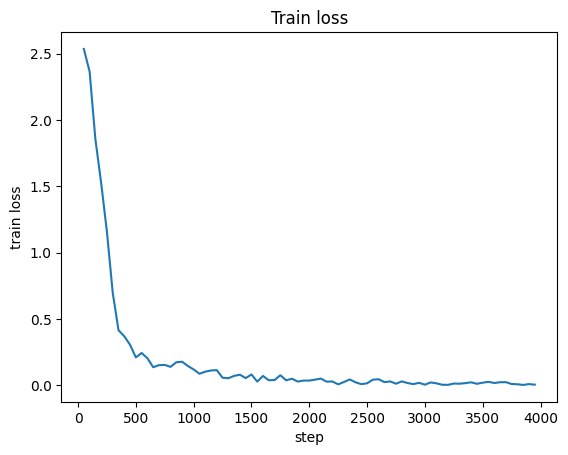

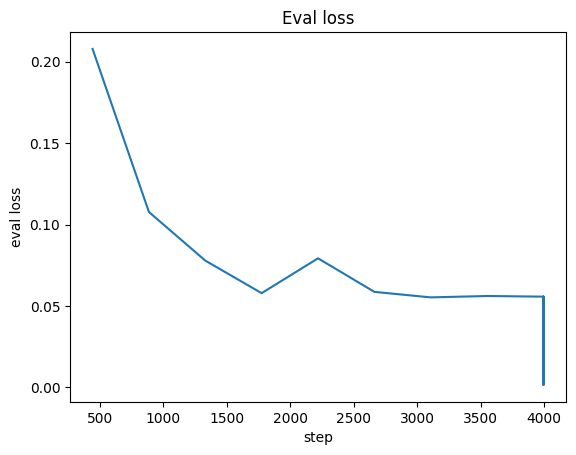

                        precision    recall  f1-score   support

        Administrative       1.00      0.92      0.96        12
  Business Development       0.99      1.00      0.99        93
            Consulting       1.00      1.00      1.00        25
      Customer Support       0.83      1.00      0.91         5
       Human Resources       1.00      1.00      1.00         5
Information Technology       0.99      0.97      0.98       196
             Marketing       1.00      1.00      1.00       644
                 Other       1.00      1.00      1.00         7
    Project Management       1.00      0.97      0.98        30
            Purchasing       1.00      1.00      1.00         6
                 Sales       0.99      1.00      0.99       499

              accuracy                           0.99      1522
             macro avg       0.98      0.99      0.98      1522
          weighted avg       0.99      0.99      0.99      1522



In [15]:
dept_trainer_base, (dept_train_pred, dept_val_pred, dept_test_pred), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_base"
)



### In-distribution performance (baseline classification)

The baseline department classification model achieves **near-perfect performance**
on the in-distribution splits (train, validation, and test).

On the training set, the model reaches an accuracy of **~0.9997** and a macro F1-score of **~0.998**,
indicating an almost perfect fit to the training data.
Validation and test performance remain similarly high, with macro F1-scores above **0.98**
and accuracy close to **1.0**.

The loss curves show fast and stable convergence.
Training loss decreases rapidly within the first epochs and approaches zero,
while validation loss decreases consistently and stabilizes without strong oscillations.
This indicates that the model converges quickly and does not suffer from obvious optimization issues.

### Per-class performance analysis (in-distribution)

The per-class classification report confirms very strong performance across all departments.
Major classes such as **Marketing**, **Sales**, and **Information Technology** achieve
precision, recall, and F1-scores close to 1.0.

Notably, even minority classes such as **Customer Support**, **Purchasing**, and **Human Resources**
show very high scores.
However, these results must be interpreted with caution, as these classes are represented
by very few samples in the validation and test sets (often fewer than 10 examples).
As a result, a small number of correct predictions can lead to artificially high metrics.

Overall, the strong per-class scores reflect that the model is able to learn
clear lexical patterns present in the fine-tuning dataset,
but they do not necessarily indicate robust generalization beyond this distribution.



In [23]:
cv_dept = jobs_annotated_df[["text", "label"]].copy()
cv_dept["labels"] = cv_dept["label"].map(label2id_dept).astype(int)

cv_dept_ds = to_hf_dataset(cv_dept, label_col="labels")

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

In [24]:
cv_dept_pred = predict_table_cls(
    dept_trainer_base,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred["correct"].mean())
print("CV F1 macro:",f1_score(cv_dept_pred["label"], cv_dept_pred["pred_label"], average="macro"))


CV accuracy: 0.27929373996789725
CV F1 macro: 0.38134361735998434


### Out-of-distribution performance on CV data (baseline)

When evaluated on the CV dataset, the baseline department classification model
shows a strong drop in performance.
The model achieves a **CV accuracy of ~0.28** and a **macro F1-score of ~0.38**,
which is substantially lower than the near-perfect in-distribution results.

This performance gap highlights a pronounced **distribution shift**
between the fine-tuning data and real-world CV job titles.
While the model performs extremely well on held-out test data from the same source,
it struggles to generalize to CV data annotated under a different labeling scheme.


To understand *which* departments are systematically confused, we visualize a confusion matrix.


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_from_pred_df(pred_df, label_order, title="Confusion matrix", normalize=None):
    y_true = pred_df["label"].astype(str).values
    y_pred = pred_df["pred_label"].astype(str).values

    cm = confusion_matrix(y_true, y_pred, labels=label_order, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f" if normalize else "d", colorbar=True)
    ax.set_title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


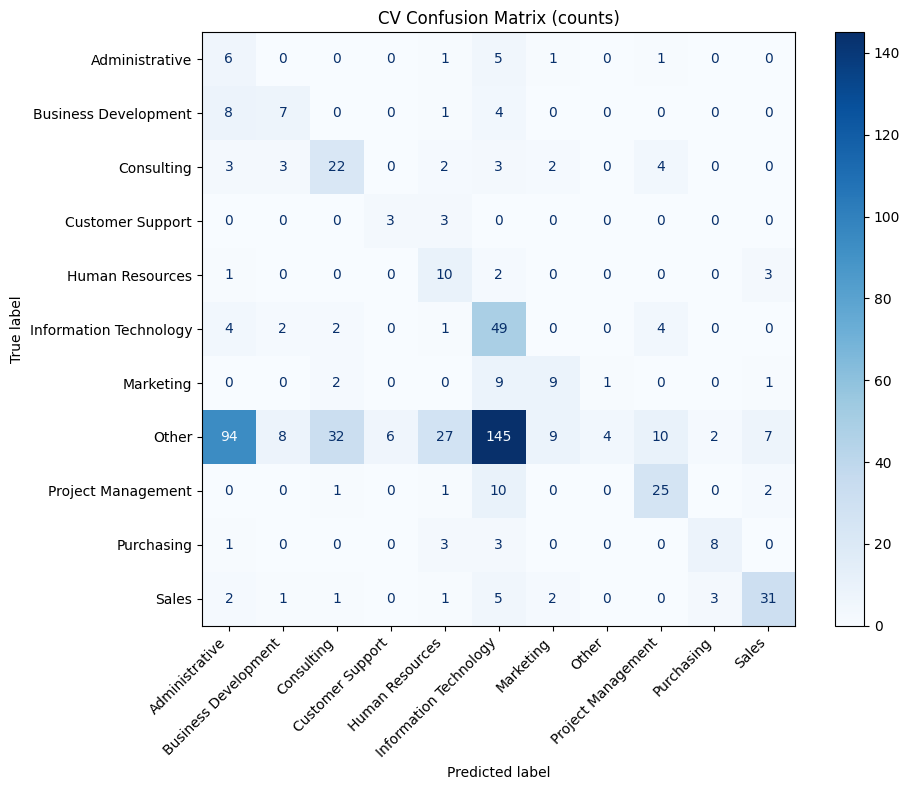

In [26]:
label_order = [id2label_dept[i] for i in range(len(id2label_dept))]

# absolute counts
plot_confusion_from_pred_df(
    cv_dept_pred,
    label_order,
    title="CV Confusion Matrix (counts)",
    normalize=None
)


## Error Analysis (CV data)

The confusion matrix reveals systematic misclassifications rather than random errors.
The most prominent issue is the **dominance of the `Other` class** in CV data.
A large fraction of CV job titles with the true label `Other`  are incorrectly predicted as *Information Technology* or *Administrative*.

This behavior suggests that the model relies heavily on lexical cues learned from the
fine-tuning dataset, which do not transfer cleanly to the broader and noisier CV titles.
In particular, the `Other` label acts as a catch-all category in the CV data,
absorbing many roles that would be more narrowly categorized in the training distribution.


Overall, the baseline classification model demonstrates excellent in-distribution fit
but fails to generalize to real-world CV data.
These results motivate the use of **data augmentation and oversampling**
in subsequent experiments to improve robustness and reduce sensitivity
to annotation and distribution differences.


### 3.2 Classification with Oversampling

Given the class imbalance observed in the department dataset,
we apply oversampling to the training split in order to increase the representation
of minority departments.
This approach aims to improve recall for underrepresented classes
and reduce the strong bias toward majority categories observed in the baseline model.


In [ ]:
dept_trainer_os, (dept_train_pred, dept_val_pred, dept_test_pred), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_os",
    do_oversample=True
)


Map:   0%|          | 0/33066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3545150955.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.037400,0.064225,0.991459,0.975401
2,0.000500,0.062295,0.992116,0.973423
3,0.000200,0.054227,0.993430,0.980112
4,0.000100,0.050661,0.994087,0.991885
5,0.000000,0.055875,0.993430,0.983383
6,0.000100,0.041437,0.995401,0.996235


In [ ]:
cv_dept_pred_os = predict_table_cls(
    dept_trainer_os,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred_os["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred_os["label"], cv_dept_pred_os["pred_label"], average="macro"))

### 3.3 Classification with synthetic data

In [ ]:
train_df_aug = add_synthetic_department(train_df_base, "data/results/gemini_synthetic.csv")

In [ ]:
# show how often the different labels occur in train_df_aug

train_df_aug["label"].value_counts()

In [ ]:
dept_trainer_aug, (dept_train_pred_aug, dept_val_pred_aug, dept_test_pred_aug), (label2id_dept, id2label_dept) = run_classification(
    train_df_aug,
    val_df_base,
    df_department_test,
    out_dir="department_cls_aug",
    do_oversample=False
)


In [ ]:
cv_dept_ds = to_hf_dataset(cv_dept, label_col="labels")
dept_trainer_aug.evaluate(cv_dept_ds)